In [1]:
import numpy as np
import visualkeras as vk 
import pandas as pd
import seaborn as sn


from keras import Model

from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Input, Conv2DTranspose, concatenate

In [2]:
train_data = np.load("../datasets/A_Z Handwritten Data/train_data.npy")
test_data = np.load("../datasets/A_Z Handwritten Data/test_data.npy")
train_labels = np.load("../datasets/A_Z Handwritten Data/train_labels.npy")
test_labels = np.load("../datasets/A_Z Handwritten Data/test_labels.npy")

In [3]:
## SIMPLE UNET

inputs = Input(train_data.shape[1:])

conv1 = Conv2D(filters=16, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = Dropout(rate=0.1) (conv1)
conv1 = Conv2D(filters=16, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (conv1)
maxpool1 = MaxPool2D(pool_size=2) (conv1)

conv2 = Conv2D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (maxpool1)
conv2 = Dropout(rate=0.2) (conv2)
conv2 = Conv2D(filters=16, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (conv2)

upconv3 = Conv2DTranspose(filters=16, kernel_size=2, strides=2, padding='same') (conv2)
upconv3 = concatenate(inputs=[upconv3, conv1], axis=3)
conv3 = Conv2D(filters=16, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (upconv3)
conv3 = Dropout(rate=0.1) (conv3)
conv3 = Conv2D(filters=16, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (upconv3)

maxpool3 = MaxPool2D(pool_size=2) (conv3)


outputs = Flatten() (maxpool3)
outputs = Dense(64, activation='relu') (outputs)
outputs = Dense(128, activation='relu') (outputs)
outputs = Dense(26, activation='softmax') (outputs)


model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy') #loss="categorical_crossentropy" loss='binary_crossentropy'
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 16)   160         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 28, 28, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 16)   2320        ['dropout[0][0]']                
                                                                                              

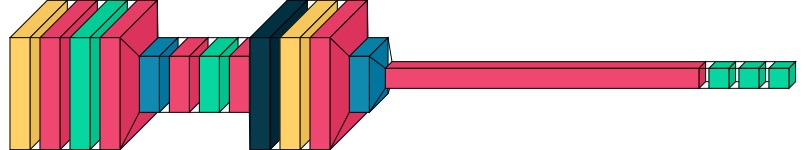

In [4]:
vk.layered_view(model)

In [5]:
best_loss_checkpoint = ModelCheckpoint(
    filepath="../datasets/A_Z Handwritten Data/models/unet-arct/best_loss_model.h5",
    monitor="loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)

best_val_loss_checkpoint = ModelCheckpoint(
    filepath="../datasets/A_Z Handwritten Data/models/unet-arct/best_val_loss_model.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)

In [6]:
history = model.fit(
    train_data,
    train_labels,
    validation_data=(test_data, test_labels), 
    epochs=10, 
    batch_size=200, 
    callbacks=[best_loss_checkpoint, best_val_loss_checkpoint]
)

Epoch 1/10
1490/1490 [==============================] - 22s 13ms/step - loss: 0.1901 - accuracy: 0.9462 - val_loss: 0.0711 - val_accuracy: 0.9795
Epoch 2/10
1490/1490 [==============================] - 18s 12ms/step - loss: 0.0667 - accuracy: 0.9810 - val_loss: 0.0613 - val_accuracy: 0.9825
Epoch 3/10
1490/1490 [==============================] - 18s 12ms/step - loss: 0.0514 - accuracy: 0.9851 - val_loss: 0.0499 - val_accuracy: 0.9856
Epoch 4/10
1490/1490 [==============================] - 18s 12ms/step - loss: 0.0419 - accuracy: 0.9875 - val_loss: 0.0444 - val_accuracy: 0.9873
Epoch 5/10
1490/1490 [==============================] - 18s 12ms/step - loss: 0.0359 - accuracy: 0.9889 - val_loss: 0.0421 - val_accuracy: 0.9877
Epoch 6/10
1490/1490 [==============================] - 18s 12ms/step - loss: 0.0300 - accuracy: 0.9905 - val_loss: 0.0392 - val_accuracy: 0.9892
Epoch 7/10
1490/1490 [==============================] - 18s 12ms/step - loss: 0.0262 - accuracy: 0.9919 - val_loss: 0.0356 -

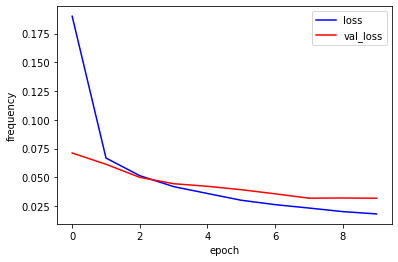

In [7]:
plt.plot(history.history["loss"], 'b', label="loss")
plt.plot(history.history["val_loss"], 'r', label="val_loss")
plt.xlabel("epoch")
plt.ylabel("frequency")
plt.legend()
plt.show()

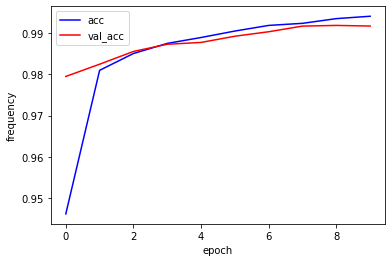

In [8]:
plt.plot(history.history["accuracy"], 'b', label="acc")
plt.plot(history.history["val_accuracy"], 'r', label="val_acc")
plt.xlabel("epoch")
plt.ylabel("frequency")
plt.legend()
plt.show()

In [9]:
model.load_weights("../datasets/A_Z Handwritten Data/models/unet-arct/best_val_loss_model.h5")

loss, acc = model.evaluate(test_data, test_labels)
print('accuracy: {:5.4f}%'.format(100 * acc))
print('val_loss: {:5.4f}%'.format(100 * loss))

2328/2328 [==============================] - 7s 3ms/step - loss: 0.0317 - accuracy: 0.9917
accuracy: 99.1717%
val_loss: 3.1745%


In [10]:
predictions = model.predict(test_data)

In [11]:
confusion = confusion_matrix(
    np.argmax(test_labels, axis=1),
    np.argmax(predictions, axis=1)
)

<AxesSubplot:xlabel='predicted', ylabel='actual'>

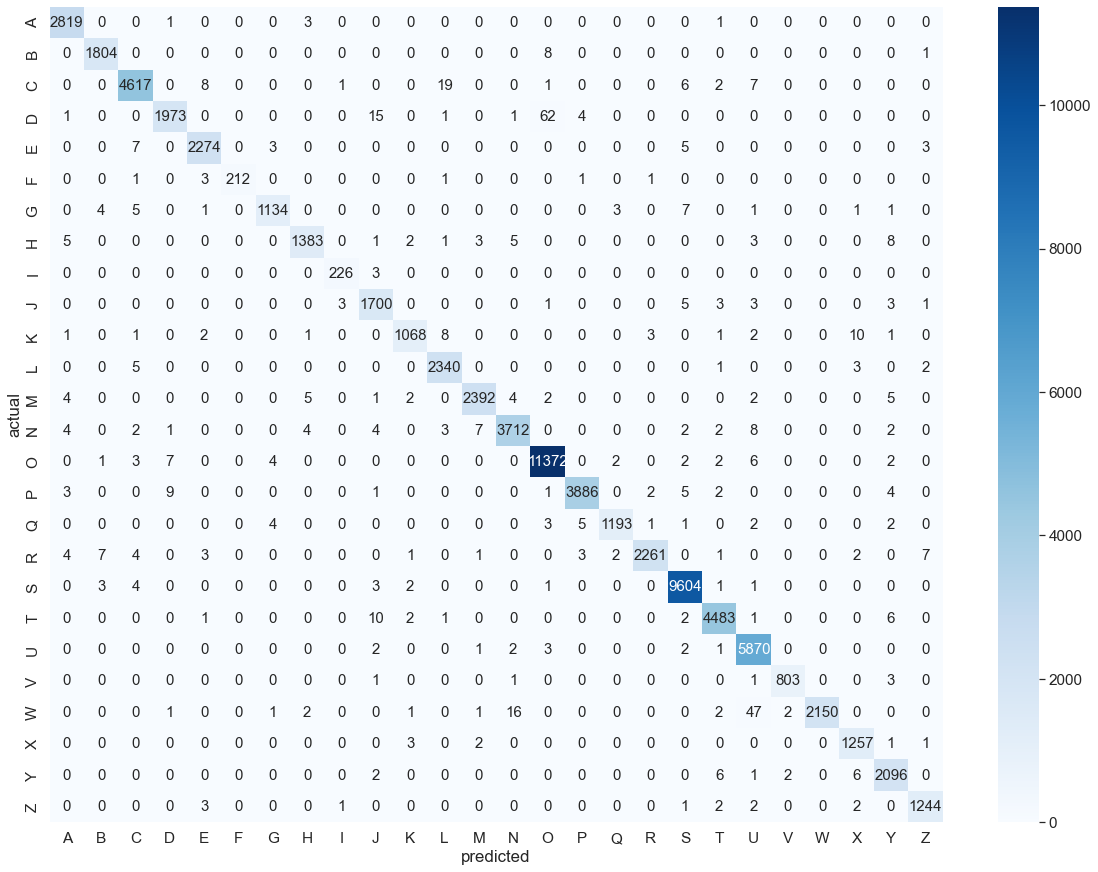

In [12]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

df_cm = pd.DataFrame(confusion, columns=np.unique(labels), index = np.unique(labels))
df_cm.index.name = 'actual'
df_cm.columns.name = 'predicted'
plt.figure(figsize = (20,15))
sn.set(font_scale=1.4) 
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 15}, fmt="d")

# How to interprete a confusion matrics